In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import os
import gc
import random
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, BertConfig, AdamW
from torch import nn
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from tqdm import tqdm
import tqdm.notebook as tq
import pickle

In [ ]:
df = pd.read_pickle('df.pkl')

In [ ]:
df

,text,toxic?,id
0,Explanation\nWhy the edits made under my usern...,0,NaN
1,D'aww! He matches this background colour I'm s...,0,NaN
2,"Hey man, I'm really not trying to edit war. It...",0,NaN
3,"""\nMore\nI can't make any real suggestions on ...",0,NaN
4,"You, sir, are my hero. Any chance you remember...",0,NaN
...,...,...,...
281274,@USER @USER Nothing about trump is human or no...,1,BC2101
281275,@USER Oh shit. That sounds like a cool time tho,1,BC2102
281276,@USER @USER I gotta say that shit to you one t...,1,BC2103
281277,@USER tRUmp does everything he can to destroy ...,1,BC2104


In [ ]:
df['toxic?'].mean()

0.18884097284191143

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tqdm.pandas()
num_tokens = 512
encoded_info = df['text'].progress_apply(
    lambda x: tokenizer.encode_plus(x,
                                    max_length = num_tokens,
                                    padding = 'max_length',
                                    return_special_tokens_mask=True,
                                    add_special_tokens=False
                                   )).values

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 281279/281279 [09:57<00:00, 470.37it/s] 


In [ ]:
df['tokens'] = [x['input_ids'] for x in encoded_info]
df['masks'] = [x['special_tokens_mask'] for x in encoded_info]

df.drop(df[df['tokens'].map(len) > num_tokens].index, inplace=True)
df.shape

(276179, 5)

In [ ]:
df['toxic?'].mean()

0.19060102324941433

In [ ]:
del encoded_info
gc.collect()

66

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
bert = BertModel.from_pretrained('bert-base-uncased', config=config).to(device)
bert.eval()

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
bert_token_indices = set()
bert_token_indices_to_indices = dict()
indices_to_token = dict()

for x in df['tokens']:
    bert_token_indices = bert_token_indices.union(set(x))

idx = 0
for x in tqdm(bert_token_indices):
    bert_token_indices_to_indices[x] = idx
    indices_to_token[idx] = tokenizer.convert_ids_to_tokens([x])
    idx += 1

100%|██████████| 28493/28493 [00:00<00:00, 243310.55it/s]


In [ ]:
num_words = len(bert_token_indices)
embedding_matrix = np.zeros((num_words, 768))
with torch.no_grad():
    for bert_idx in tqdm(bert_token_indices):
        idx = bert_token_indices_to_indices[bert_idx]
        embedding_matrix[idx] = bert(torch.tensor([[bert_idx]]).to(device),
                                     torch.tensor([[1]]).to(device))[2][0][0][0].cpu().numpy()

100%|██████████| 28493/28493 [04:50<00:00, 98.22it/s] 


In [ ]:
del tokenizer
del bert
del config
gc.collect()

72

In [ ]:
BATCH_SIZE = 16
n_batches = df.shape[0] // BATCH_SIZE

tokens = [[bert_token_indices_to_indices[x] for x in y] for y in df['tokens'].tolist()]

train_dataset = TensorDataset(torch.tensor(np.matrix(tokens)),
                              torch.tensor(df['toxic?'].astype(int).values.tolist()),
                              torch.tensor(df['masks'].tolist()))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

del tokens
del train_dataset
gc.collect()

0

In [ ]:
class ClassifierModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embeddings=torch.tensor(embedding_matrix),
            freeze=True)
        
        self.gru1 = nn.GRU(
            input_size=768,
            hidden_size=32,
            num_layers=1,
            batch_first=True,
            bidirectional=True)
        self.gru2 = nn.GRU(
            input_size=64,
            hidden_size=1,
            num_layers=1,
            batch_first=True,
            bidirectional=True)
        
        self.linear1 = nn.Linear(in_features=768, out_features=64)
        self.linear2 = nn.Linear(in_features=64, out_features=1)
        
    def forward(self, input_ids, pad_masks, labels=None):
        
        w = self.embedding(input_ids)
        h = nn.Tanh()(self.linear1(w))
        p = nn.Sigmoid()(self.linear2(h)).squeeze(dim=2)
        
        g1 = nn.LeakyReLU(0.1)(self.gru1(w)[0])
        g2 = self.gru2(g1)[0]
        a = nn.Sigmoid()(torch.sum(g2, dim=-1))
        
        masks = 1 - pad_masks
        a = a * masks
        A = torch.div(a, torch.tensor(torch.sum(a, dim=1)).reshape((-1, 1)))
        
        Y = torch.sum(A * p, dim=1)
        
        loss = 0
        if labels is not None:
            loss = (
                nn.BCELoss()(Y, labels.double()) +
                0.01 * (nn.MSELoss()(torch.max(a, dim=1).values, labels.double()) +
                torch.mean((torch.min(torch.where(masks == 1, a, torch.ones_like(a)), dim=1).values ** 2)))
            )
        return loss, Y, p, a

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassifierModel().double().to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=3e-6)
if device.type == 'gpu':
    torch.cuda.empty_cache()

In [ ]:
EPOCHS = 5
batch_losses = []

for epoch_num in range(EPOCHS):
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader)):
        token_ids, labels, special_tokens = tuple(t.to(device) for t in batch_data)

        loss, _, _, _ = model(
            input_ids=token_ids,
            labels=labels,
            pad_masks=special_tokens)

        train_loss += loss.item()
        
        model.zero_grad()
        loss.backward()        

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        batch_losses.append(train_loss / (step_num + 1))

100%|██████████| 17262/17262 [18:31<00:00, 15.53it/s]


In [ ]:
torch.save(model.state_dict(), 'model')

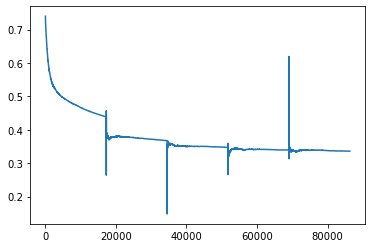

In [ ]:
plt.plot(batch_losses)

In [ ]:
with open('loss.pkl', 'wb') as fh:
   pickle.dump(batch_losses, fh)

In [ ]:
del batch_losses
gc.collect()

44

In [ ]:
df = df[df['toxic?'] == 1]

tokens = [[bert_token_indices_to_indices[x] for x in y] for y in df['tokens'].tolist()]

train_dataset = TensorDataset(torch.tensor(np.matrix(tokens)),
                              torch.tensor(df['toxic?'].astype(int).values.tolist()),
                              torch.tensor(df['masks'].tolist()))
train_sampler = SequentialSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

del tokens
del df
del train_dataset
del train_sampler
del bert_token_indices
del bert_token_indices_to_indices
gc.collect()

0

In [ ]:
test_tokens = []
test_preds = []
test_scores = []
test_Y = []
test_labels = []

model.eval()
with torch.no_grad():
    for step_num, batch_data in enumerate(tqdm(train_dataloader)):
        token_ids, labels, special_tokens = tuple(t.to(device) for t in batch_data)
        _, Y, preds, scores = model(input_ids=token_ids, pad_masks=special_tokens)
        for sample_tokens, sample_Y, sample_preds, sample_scores, sample_label, sample_special_tokens in zip(
            token_ids.tolist(),
            Y.tolist(),
            preds.tolist(),
            scores.tolist(),
            labels.tolist(),
            special_tokens):
            
                l = 512 - sample_special_tokens.sum()
                test_tokens.append(sample_tokens[:l])
                test_Y.append(sample_Y)
                test_preds.append(sample_preds[:l])
                test_scores.append(sample_scores[:l])
                test_labels.append(sample_label)

100%|██████████| 3290/3290 [01:37<00:00, 33.88it/s]


In [ ]:
del model
del train_dataloader
gc.collect()

58

In [ ]:
df = pd.DataFrame(
    {
        'tokens': [[indices_to_token[x][0] for x in y] for y in test_tokens],
        'Y': test_Y,
        'scores': test_scores,
        'preds': test_preds,
        'label': test_labels
    }
)
df

,tokens,Y,scores,preds,label
0,"[cock, ##su, ##cker, before, you, piss, around...",0.534244,"[0.7692446999392344, 0.7547650090924806, 0.755...","[0.9980199199041843, 0.1607601419306211, 0.932...",1
1,"[hey, ., ., ., what, is, it, ., ., @, |, talk,...",0.115351,"[0.28525191277353157, 0.2882144006299423, 0.28...","[0.8591586487311573, 0.00022262220416152139, 0...",1
2,"[bye, !, don, ', t, look, ,, come, or, think, ...",0.258062,"[0.39329042137003545, 0.3742630414962807, 0.35...","[0.06888390575559493, 0.896935948697345, 0.750...",1
3,"[you, are, gay, or, anti, ##se, ##mm, ##itia, ...",0.274985,"[0.5547501019038182, 0.5123795762775145, 0.451...","[0.9666784776679549, 0.0012887115024622074, 0....",1
4,"[fuck, your, filthy, mother, in, the, ass, ,, ...",0.631085,"[0.860464287606661, 0.8660522906890008, 0.8671...","[0.9999683047774107, 0.8822553014860401, 0.995...",1
...,...,...,...,...,...
52635,"[@, user, @, user, nothing, about, trump, is, ...",0.286324,"[0.8600023875093349, 0.8619748730202039, 0.863...","[0.9981626629396194, 0.026111485995796747, 0.9...",1
52636,"[@, user, oh, shit, ., that, sounds, like, a, ...",0.388210,"[0.8756520764060685, 0.8762362685538518, 0.876...","[0.9981626629396194, 0.026111485995796747, 0.8...",1
52637,"[@, user, @, user, i, gotta, say, that, shit, ...",0.264048,"[0.8410594094836469, 0.8419167819725226, 0.841...","[0.9981626629396194, 0.026111485995796747, 0.9...",1
52638,"[@, user, trump, does, everything, he, can, to...",0.152094,"[0.7820550636826707, 0.7871733810950804, 0.775...","[0.9981626629396194, 0.026111485995796747, 0.3...",1


In [ ]:
df.to_pickle('df_results.pkl')

(array([   5.,   10.,   17.,   27.,   74.,  116.,  182.,  256.,  386.,
         419.,  604.,  713.,  814.,  936.,  947., 1007., 1063., 1082.,
        1107., 1250., 1270., 1249., 1262., 1280., 1278., 1279., 1345.,
        1301., 1274., 1355., 1378., 1294., 1209., 1245., 1248., 1290.,
        1246., 1183., 1186., 1154., 1070., 1047.,  984.,  962.,  894.,
         860.,  788.,  767.,  728.,  745.,  648.,  614.,  522.,  511.,
         462.,  457.,  413.,  362.,  338.,  302.,  248.,  235.,  232.,
         179.,  167.,  166.,  133.,  132.,  110.,  119.,  100.,   96.,
          66.,   77.,   65.,   59.,   53.,   47.,   55.,   37.,   38.,
          27.,   30.,   32.,   34.,   21.,   17.,   17.,   15.,   14.,
          11.,   14.,   11.,   12.,   16.,   22.,   21.,   18.,   38.,
          41.]),
 array([0.00272843, 0.01270083, 0.02267323, 0.03264563, 0.04261803,
        0.05259043, 0.06256283, 0.07253523, 0.08250762, 0.09248002,
        0.10245242, 0.11242482, 0.12239722, 0.13236962, 0.14234202

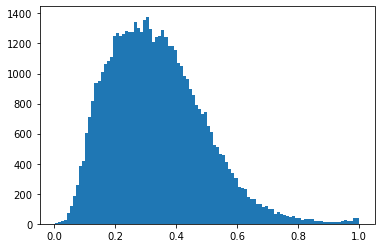

In [ ]:
plt.hist(df['Y'], bins=100)

In [ ]:
df[df['Y'] >= 0.5]

,tokens,Y,scores,preds,label
0,"[cock, ##su, ##cker, before, you, piss, around...",0.534244,"[0.7692446999392344, 0.7547650090924806, 0.755...","[0.9980199199041843, 0.1607601419306211, 0.932...",1
4,"[fuck, your, filthy, mother, in, the, ass, ,, ...",0.631085,"[0.860464287606661, 0.8660522906890008, 0.8671...","[0.9999683047774107, 0.8822553014860401, 0.995...",1
6,"[get, fucked, up, ., get, fuck, ##ee, ##ed, up...",0.512297,"[0.735136501246793, 0.7424310535909308, 0.7427...","[0.9782661188057149, 0.9998679575342433, 0.737...",1
7,"[stupid, peace, of, shit, stop, del, ##eti, ##...",0.503912,"[0.7514214552825695, 0.759678979659358, 0.7606...","[0.999314555739647, 0.014240151639414082, 0.00...",1
20,"[you, are, a, stupid, fuck, and, your, mother,...",0.561650,"[0.7479016927678895, 0.7512370705555216, 0.755...","[0.9666784776679549, 0.0012887115024622074, 0....",1
...,...,...,...,...,...
52389,"[man, i, fucking, love, ram]",0.736795,"[0.81184411106198, 0.8202125375597974, 0.83551...","[0.9853082740763375, 0.008997308648915446, 0.9...",1
52407,"[childish, as, fuck, son, .]",0.515756,"[0.7380026071954245, 0.7405564804121872, 0.769...","[0.6779572965388223, 0.00012600330778772314, 0...",1
52497,"[shut, the, fuck, om, ##g, no, one, cares, damn]",0.503686,"[0.7386480272213372, 0.7465019762343019, 0.814...","[0.9554411832696198, 0.0003755713900746279, 0....",1
52548,"[bro, my, neighbor, is, a, fucking, dumb, ##as...",0.503979,"[0.8060458344358248, 0.8211390584786465, 0.823...","[0.9173511098398797, 0.7553135480535125, 0.009...",1
